### Importing Necessary Packages

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.notebook import tqdm

### Convolution Block Emplementation

In [3]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        '''
        in_channels: Number of Channels entering the convolution layer
        out_channels: Number of filter for the convolution layer
        '''
        super(ConvolutionBlock, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

    def forward(self, X):
        return self.convs(X)

### Classifier class

In [4]:
class Classifier(nn.Module):
    def __init__(self, in_channels: int,  num_classes: int) -> None:
        super(Classifier, self).__init__()

        conv1 = ConvolutionBlock(in_channels=in_channels, out_channels=8)
        dropout1 = nn.Dropout2d(0.5)
        conv2 = ConvolutionBlock(in_channels=8, out_channels=16)
        dropout2 = nn.Dropout2d(0.5)
        conv3 = ConvolutionBlock(in_channels=16, out_channels=32)

        self.layers = nn.Sequential(conv1,dropout1, conv2,dropout2, conv3)

        self.fc = nn.Sequential(
            nn.Linear(in_features=1152, out_features=40),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=40, out_features=20),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=20, out_features=num_classes),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X):
        X = self.layers(X)
        X = X.view(X.shape[0], -1)
        X = self.fc(X)
        return X

In [5]:
def get_dataloaders(path: str, training: bool):
    '''
    returns a dataloader object given a path to a directory depending on whether or not it is a trainset
    '''
    transforms = None
    if training:
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((64, 64)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.RandomHorizontalFlip()
        ])
    else:
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((64, 64)),
            torchvision.transforms.ToTensor()
        ])

    data = torchvision.datasets.ImageFolder(
        path, transform=transforms)

    data_loader = DataLoader(data, batch_size=32, shuffle=training)

    return data_loader

In [6]:
def calculate_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy

In [7]:
# def train_model(model=Classifier(in_channels=3, num_classes=4)):

train_loss = []
train_acc = []
val_loss = []
val_acc = []

model = Classifier(in_channels=3, num_classes=4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
EPOCHS = 30
train_loader = get_dataloaders(path='Mask_Data/train', training=True)
valid_loader = get_dataloaders(path='Mask_Data/val', training=False)
model.train()
for epoch in tqdm(range(EPOCHS)):
    # for batch_idx, (inputs, labels) in enumerate(train_loader):
    for batch in train_loader:
        inputs, labels = batch

        # Forward pass
        y_pred = model.forward(inputs)
        # print('y_pred shape: ', y_pred.shape)

        # Calculating Accuracy
        _, predicted = torch.max(y_pred, dim=1)
        train_accuracy = calculate_accuracy(y_true = labels, y_pred = predicted)

        # Calculating loss
        loss = criterion(input=y_pred, target=labels)

        # BackPropagation
        loss.backward()
        optimizer.step()

        # Zero Gradients
        optimizer.zero_grad()

        #train_loss.append(loss.item())

    with torch.no_grad():
        validation_loss = 0
        model.eval()
        for batch in valid_loader:
            val_input, val_labels = batch
            preds = model.forward(val_input)
            _, eval_preds = torch.max(preds, dim=1)
            
            valid_accuracy = calculate_accuracy(y_true = val_labels, y_pred = eval_preds)
            
            valid_loss = criterion(input=preds, target=val_labels)

            validation_loss += valid_loss.item()
            #val_loss.append(validation_loss)
    
    
    train_loss.append(loss.item())
    train_acc.append(train_accuracy)
    val_loss.append(validation_loss)
    val_acc.append(valid_accuracy)
    print('Epoch: {}, Loss: {}, Train Accuracy: {}, Val Accuracy: {}'.format(
        epoch, loss.item(), train_accuracy, valid_accuracy))


#model = train_model()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.9224529266357422, Train Accuracy: 60.0, Val Accuracy: 0.0
Epoch: 1, Loss: 0.6939372420310974, Train Accuracy: 66.66666666666666, Val Accuracy: 71.42857142857143
Epoch: 2, Loss: 0.6485475301742554, Train Accuracy: 93.33333333333333, Val Accuracy: 85.71428571428571
Epoch: 3, Loss: 0.11535558104515076, Train Accuracy: 93.33333333333333, Val Accuracy: 85.71428571428571
Epoch: 4, Loss: 0.2670801281929016, Train Accuracy: 93.33333333333333, Val Accuracy: 80.95238095238095
Epoch: 5, Loss: 0.04476175457239151, Train Accuracy: 100.0, Val Accuracy: 85.71428571428571
Epoch: 6, Loss: 0.07053805142641068, Train Accuracy: 100.0, Val Accuracy: 85.71428571428571
Epoch: 7, Loss: 0.007117695640772581, Train Accuracy: 100.0, Val Accuracy: 95.23809523809523
Epoch: 8, Loss: 0.07834400981664658, Train Accuracy: 93.33333333333333, Val Accuracy: 95.23809523809523
Epoch: 9, Loss: 0.09756294637918472, Train Accuracy: 93.33333333333333, Val Accuracy: 100.0
Epoch: 10, Loss: 0.0260440893471241, T

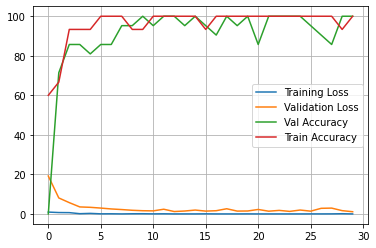

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.plot(val_acc, label = 'Val Accuracy')
plt.plot(train_acc, label = 'Train Accuracy')
plt.grid()
plt.legend()
plt.show()
plt.close()

## Test Set

In [9]:
test_set = get_dataloaders(path='Mask_Data/test', training=False)
with torch.no_grad():
        test_loss = 0
        model.eval()
        for batch in test_set:
            test_input, test_labels = batch
            preds = model.forward(test_input)
            _, test_preds = torch.max(preds, dim=1)
            
            test_accuracy = calculate_accuracy(y_true = test_labels, y_pred = test_preds)
            
            #valid_loss = criterion(input=preds, target=val_labels)

            #validation_loss += valid_loss.item()
print(test_accuracy)

92.0
